In [1]:
#Import des libraires 
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
#Reading poloniex api, period is in seconds, start is timestamp for 1/1/2017, pair is USDT ETH.
pair = "USDT_ETH"
start = "1483228800"
period = "300"

print('On charge data')
#Since the API gives a json file we directly transform it to pandas dataframe.
#ajouter convert_date pour parser automatiquement les dates
df = pd.read_json("https://poloniex.com/public?command=returnChartData&currencyPair="+pair+"&start="+start+"&end=9999999999&period="+period,convert_dates=['date'])

On charge data


In [3]:
#mettre la date en index, panads comprend que c'est une timeseries
df=df.set_index('date')

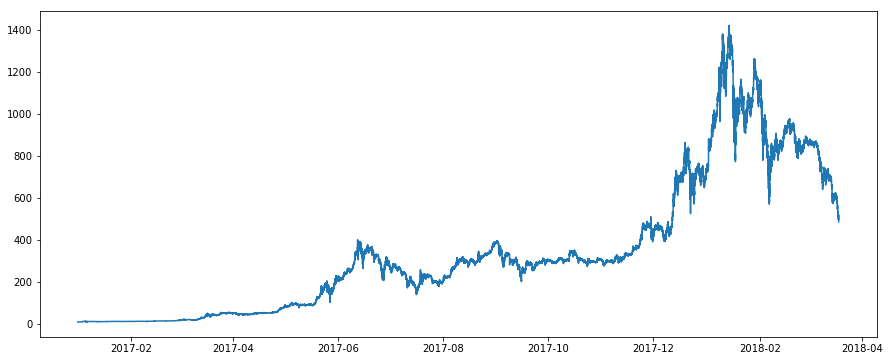

In [4]:
plt.plot(df['weightedAverage'])

In [4]:
#moyenne glissante sur une journée et test de stationnarité de la timeseries
import matplotlib.dates as dates
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=288,center=False).mean() 
    rolstd = timeseries.rolling(window=288,center=False).std()

    #Plot rolling statistics:
    fig, ax= plt.subplots()
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Moyenne glissante & Standard Deviation')
   
    ax.xaxis.grid(True, which="major")
    ax.yaxis.grid()
    ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
    plt.show(block=False)
    
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [5]:
test_stationarity(df['weightedAverage'])

ValueError: ordinal must be >= 1

Results of Dickey-Fuller Test:


MemoryError: 

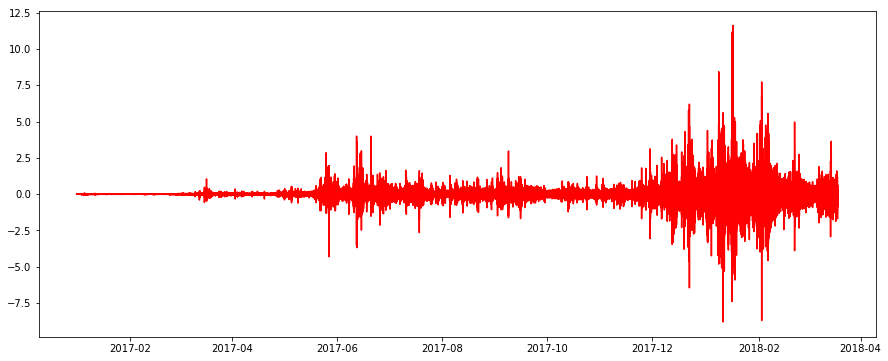

In [5]:
#Implémentation d'une ARIMA
model = ARIMA(df['weightedAverage'], order=(2, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(results_ARIMA.fittedvalues, color='red')

In [6]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log2 = pd.Series(df['weightedAverage'].ix[0], index=df['weightedAverage'].index)
predictions_ARIMA_log = predictions_ARIMA_log2.add(predictions_ARIMA_diff_cumsum,fill_value=0)

In [7]:
ts_week_log=df['weightedAverage']
size = int(len(ts_week_log) - 15)
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f, day=%s, diff=%f' % (yhat, obs,str(test.index[t]),(yhat-obs)*100/yhat))

error = mean_squared_error(test, predictions)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

#predictions_series = pd.Series(predictions, index = t.index)

Printing Predicted vs Expected Values...


predicted=515.881493, expected=511.367124, day=2018-03-18 12:25:00, diff=0.875079
predicted=510.475344, expected=508.552832, day=2018-03-18 12:30:00, diff=0.376612
predicted=508.387956, expected=507.016625, day=2018-03-18 12:35:00, diff=0.269741
predicted=507.023549, expected=508.525635, day=2018-03-18 12:40:00, diff=-0.296256
predicted=508.942627, expected=510.131375, day=2018-03-18 12:45:00, diff=-0.233572
predicted=510.310302, expected=500.993181, day=2018-03-18 12:50:00, diff=1.825776
predicted=499.306053, expected=500.780105, day=2018-03-18 12:55:00, diff=-0.295220
predicted=501.448266, expected=503.153295, day=2018-03-18 13:00:00, diff=-0.340021
predicted=503.672287, expected=498.283232, day=2018-03-18 13:05:00, diff=1.069953
predicted=497.288676, expected=496.167009, day=2018-03-18 13:10:00, diff=0.225557
predicted=496.171910, expected=496.348251, day=2018-03-18 13:15:00, diff=-0.035540
predicted=496.598347, expected=492.032701, day=201